# MCMC for finite state space

Backwards filtering for tree with observations at the leaf nodes following the finite state space example and algorithm in https://arxiv.org/abs/2203.04155 .

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
print(sys.executable)

from jax.random import PRNGKey, split
import hyperiax
import jax
from jax import numpy as jnp
from hyperiax.execution import LevelwiseTreeExecutor
from hyperiax.models import UpLambda
from hyperiax.models.functional import product_fuse_children
from hyperiax.mcmc import Parameter, ParameterStore, UniformParameter, VarianceParameter
from hyperiax.mcmc.metropolis_hastings import metropolis_hastings
from hyperiax.mcmc.plotting import trace_plots

import matplotlib.pyplot as plt
from tqdm import tqdm

import math
from Bio import Phylo
from io import StringIO
from functools import reduce

/Users/sara/anaconda3/envs/hyperiax/bin/python


In [3]:
key = PRNGKey(42)

In [4]:
# Updated UniformParameter for MCMC
class UniformParameter(Parameter):
    def __init__(self, value, min=0., max=1., keep_constant=False) -> None:
        super().__init__(value)
        self.min = min
        self.max = max
        self.keep_constant = keep_constant

    def propose(self, key):
        if self.keep_constant:
            return self

        return UniformParameter(jax.random.uniform(key, minval=self.min, maxval=self.max), self.min, self.max,
                                self.keep_constant)

    def update(self, value, accepted):
        if accepted:
            self.value = value

    def log_prior(self):
        return 0.

# Create tree
First, we initialize the tree with for each node the type, value, and log_sum (norm).

Tree: HypTree with 5 levels and 9 nodes
 *
 │
 *
┌┴─┐
*  * 
│ ┌┴┐
* * *
│ │  
* *


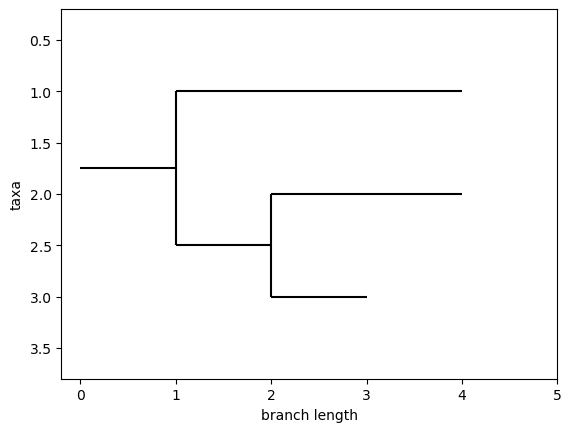

In [5]:
from hyperiax.tree import HypTree, TreeNode
from hyperiax.tree.childrenlist import ChildList

# example tree, see Figure 1 / Figure 4 tree in https://arxiv.org/abs/2203.04155
root = TreeNode();  # x_{-1}
x0 = TreeNode(); x0.parent = root; root.children = ChildList([x0])
x1 = TreeNode(); x1.parent = x0;
x3 = TreeNode(); x3.parent = x0;
x0.children = ChildList([x1, x3])
x2 = TreeNode(); x2.parent = x1; x1.children = ChildList([x2])
v3 = TreeNode(); v3.parent = x2; x2.children = ChildList([v3])
x4 = TreeNode(); x4.parent = x3;
v2 = TreeNode(); v2.parent = x3; x3.children = ChildList([x4, v2])
v1 = TreeNode(); v1.parent = x4; x4.children = ChildList([v1])
v1.children = v2.children = v3.children = ChildList()

tree = HypTree(root)
print('Tree:', tree)
tree.plot_tree_text()

# types for right transitions
troot = 0; tinner_node = 1; tleaf_node = 2;
tree.root['type'] = troot
x1['type'] = x2['type'] = x3['type'] = x4['type'] = tinner_node
v1['type'] = v2['type'] = v3['type'] = tleaf_node

# number of states
R = 3

# root value
tree.root['value'] = jnp.zeros(R)

# observations
v1['value'] = jnp.eye(R)[0]
v2['value'] = jnp.eye(R)[1]
v3['value'] = jnp.eye(R)[2]

# transition matrices
x0['type'] = troot

# initialize log_sum as data of all nodes
for i in tree.iter_bfs():
    i['log_sum'] = 0

# save tree figure
Phylo.draw(Phylo.read(StringIO(tree.to_newick()), "newick"), branch_labels=lambda c: c.branch_length, do_show=False)
plt.savefig('PDF_Tree.png')

# prior kernel
pi1 = pi2 = pi3 = 1 / 3;
km10 = lambda params: jnp.diag([pi1, pi2, pi3])

# inner node kernel
kst = lambda params: jnp.array([[1. - params['theta'], params['theta'], 0.],
                                [.25, .5, .25],
                                [.4, .3, .3]])

# leaves kernel
lambdi = lambda params: jnp.array([[1., 1., 0.],
                                   [1., 1., 0.], 
                                   [0., 0., 1.]])

# transition function for up_fn, kernel*value
def transition(value, type, params):
    return jax.lax.cond(type == tinner_node,
                        lambda: jnp.dot(kst(params), value),
                        lambda: jax.lax.cond(type == tleaf_node,
                                             lambda: jnp.dot(lambdi(params), value),
                                             lambda: jnp.array([pi1, pi2, pi3])
                                            )
                       )


Parameter for the inner transition kernel.

In [6]:
# parameter, theta with uniform prior as the initial value of 0.5
params = ParameterStore({
    'theta': UniformParameter(.5),  # theta parameter for kst
})

We now define the backwards filter through the up and fuse functions. In this case, the up operation is first a matrix multiplication and then a dot product of the children.

In [7]:
# backwards filter
def up(value, type, params, **args):
    def f(value, type):
        return {'value': transition(value, type, params)}
    return jax.vmap(f)(value, type)

# Normalized product of the children
def norm_product_fuse(**kwargs):
    value = reduce(lambda x, y: x * y, kwargs['child_value']).reshape(-1)
    new_value = value / jnp.linalg.norm(value)
    log_sum = math.log(jnp.linalg.norm(value))
    return {'value': new_value, 'log_sum': log_sum}

We create the model and executor for the backwards filter (up) with the normalized product of the values after joining them.

In [8]:
# create model and executor
upmodel = UpLambda(up_fn=up, fuse_fn=norm_product_fuse)
upexec = LevelwiseTreeExecutor(upmodel)

In [9]:
# execture backwards filter
utree = upexec.up(tree, params.values())

# prior is also normalized which I avoided 
utree.root.data['log_sum'] = 0
utree.root.data['value'] = jnp.array([pi1, pi2, pi3])

# print results and calculate total to be added later
total_log_sum = 0
for node in utree.iter_bfs():
    print(node.data)
    total_log_sum += node.data['log_sum']


{'type': 0, 'value': Array([0.33333334, 0.33333334, 0.33333334], dtype=float32), 'log_sum': 0}
{'type': 0, 'log_sum': -0.9150115257595711, 'value': Array([0.5594453 , 0.63936603, 0.527477  ], dtype=float32)}
{'type': 1, 'log_sum': -0.9402953096177683, 'value': Array([0.        , 0.6401844 , 0.76822126], dtype=float32)}
{'type': 1, 'log_sum': -0.12343010665625444, 'value': Array([0.8, 0.6, 0. ], dtype=float32)}
{'type': 1, 'log_sum': 0.0, 'value': Array([0., 0., 1.], dtype=float32)}
{'type': 1, 'log_sum': 0.3465735731657015, 'value': Array([0.70710677, 0.70710677, 0.        ], dtype=float32)}
{'type': 2, 'value': Array([0., 1., 0.], dtype=float32), 'log_sum': 0}
{'type': 2, 'value': Array([0., 0., 1.], dtype=float32), 'log_sum': 0}
{'type': 2, 'value': Array([1., 0., 0.], dtype=float32), 'log_sum': 0}


# Likelihood Computation
We compute the likelihood as the dot product of the prior kernel and the value at the root, plus the norms of the normalized values.

In [10]:
# Likelihood = log(prior * h0) + log(sum norm)
prior_vec = utree.root.data['value']
h0_vec = utree.root.children[0].data['value']

log_lik = math.log(jnp.dot(prior_vec, h0_vec)) + total_log_sum
print(f"The log-likelihoog is {log_lik}")

The log-likelihoog is -2.1848020344253407


# MCMC 

Metropolis-Hastings with likelihood funcion as in previous section and prior distribution for parameter theta as inverse gamma distribution

In [11]:
def log_likelihood(state):
    """ Log likelihood of the tree """
    parameters, tree = state

    tree.root.data['log_sum'] = 0
    tree.root.data['value'] = jnp.array([pi1, pi2, pi3])

    total_log_sum = 0
    for node in tree.iter_bfs():
        total_log_sum += node.data['log_sum']

    prior_vec = tree.root.data['value']
    h0_vec = tree.root.children[0].data['value']

    log_like = math.log(jnp.dot(prior_vec, h0_vec)) + total_log_sum
    return log_like

def log_posterior(data, state):
    """ Log posterior given the state and data """
    parameters, tree = state

    log_like = log_likelihood(state)
    log_prior = parameters.log_prior()
    return log_prior + log_like

def proposal(data, state, key):
    """ Propose new parameter theta for model """ 
    parameters, tree = state

    new_parameters = parameters.propose(key)
    new_tree = tree.copy()
    init_up(new_tree, new_parameters)
    new_tree = upexec.up(new_tree, new_parameters.values())

    return new_parameters, new_tree

Now we define the Metropolis-Hastings Algorithm for those functions.

In [12]:
def init_up(t, params):
    for node in t.iter_bfs():
        if node.children and node.parent:
            node.data['log_sum'] = 0
            del node.data['value']
        else:
            node.data = {**node.data, 'value': node['value'], 'log_sum': 0}
            
# tree values and parameters
init_params = ParameterStore({
    'theta': UniformParameter(0.001),  # Better Results
    #'theta': VarianceParameter(0.001),   # Convergence could be better
})
print("Initial parameters: ", init_params.values())
print("data parameters: ", params.values())

# initial state
dtree = utree.copy()
init_up(dtree, init_params)
init_state = (init_params, upexec.up(dtree, init_params.values()))

# Run Metropolis-Hastings
subkey, key = split(key)
log_likelihoods, samples = metropolis_hastings(log_posterior, proposal, dtree, init_state, 2000,
                                               burn_in=100, rng_key=key, savef=lambda state: state[0])


Initial parameters:  {'theta': 0.001}
data parameters:  {'theta': 0.5}


100%|███████████████████████████████████████| 2100/2100 [01:26<00:00, 24.41it/s]

Acceptance rate: 0.9057


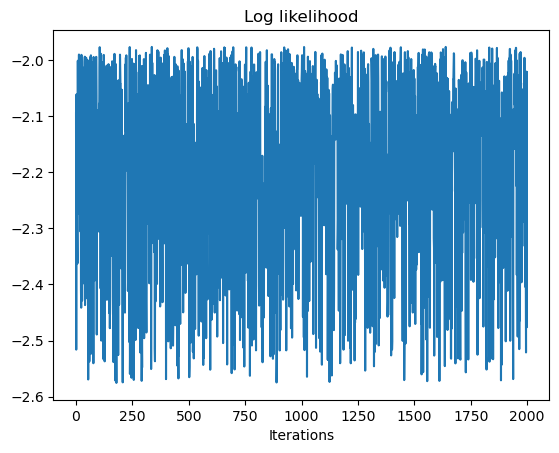

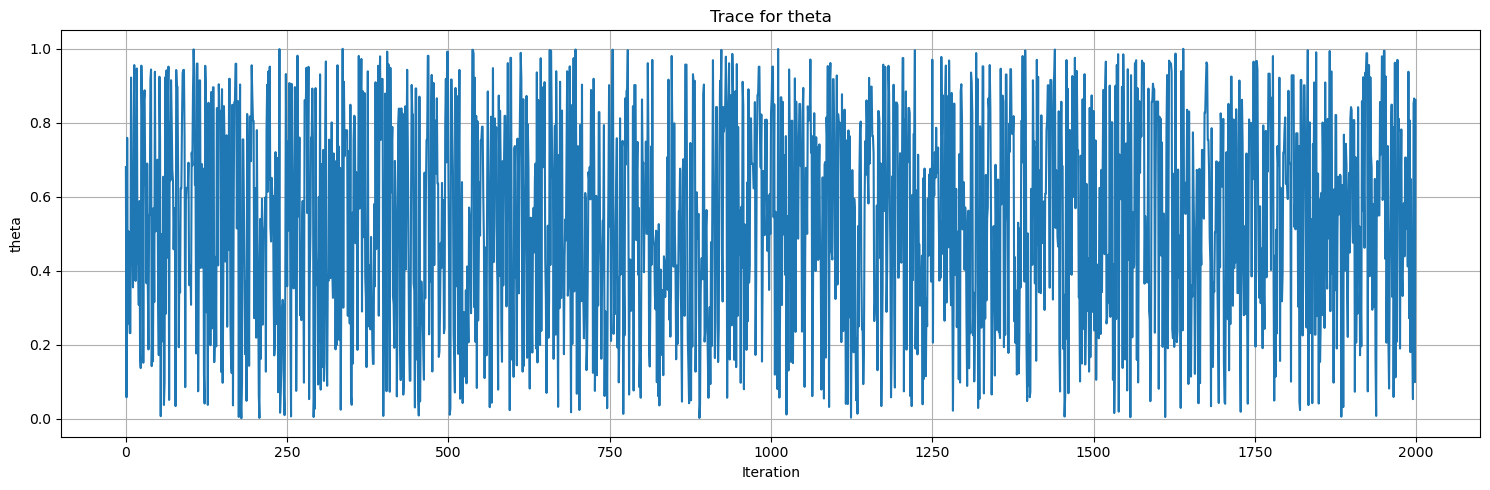

In [13]:
# plot samples
plt.plot(log_likelihoods)
plt.xlabel("Iterations")
plt.title('Log likelihood')
plt.savefig("PDF_LogLike_Trace.png")

import numpy as np
# Determine grid layout
num_params = len(samples[0])
num_rows = int(jnp.sqrt(num_params))
num_cols = num_params // num_rows + (num_params % num_rows > 0)

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5))
axes = np.atleast_2d(axes)  # Ensure axes is always 2D array

# Plot traces
for ax, (i, param) in zip(axes.ravel(), enumerate(samples[0].values().keys())):
    ax.plot(np.array([sample[param].value for sample in samples]))
    ax.set_title(f"Trace for {param}")
    ax.set_xlabel('Iteration')
    ax.set_ylabel(param)
    ax.grid(True)

plt.tight_layout()
plt.savefig("PDF_Theta_Trace.png")
plt.show()

# trace_plots(samples)

97.5% HPD Interval for theta: (0.07324803, 0.9971633)
Posterior mean theta: 0.5388097763061523
Posterior median theta: 0.5539134740829468
Posterior variance theta: 0.08095504343509674
The effective sample size for theta: 1440.9491127836718


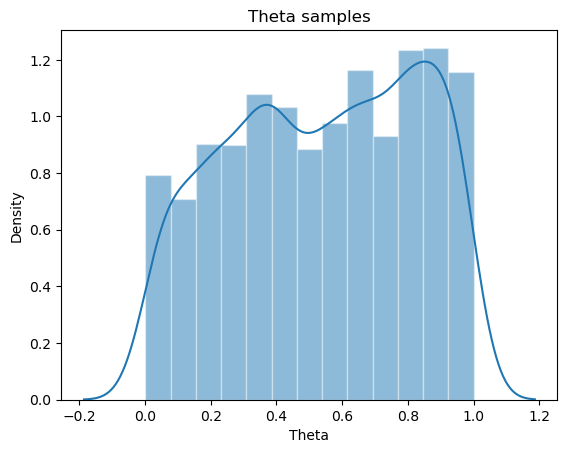

In [14]:
# Theta Sample Analysis 
import arviz as az
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

values_list = [param_store.values()['theta'] for param_store in samples]
theta_samples = np.array(values_list)

# 97.5% HPD intervals
hpd_interval = az.hdi(theta_samples, credible_interval=0.975)
print(f"97.5% HPD Interval for theta: {hpd_interval[0], hpd_interval[1]}")

# Posterior mean
posterior_mean = np.mean(theta_samples, axis=0)
print(f"Posterior mean theta: {posterior_mean}")

# Posterior median 
posterior_median = np.median(theta_samples)
print(f"Posterior median theta: {posterior_median}")

# Posterior variance 
posterior_variance = np.var(theta_samples)
print(f"Posterior variance theta: {posterior_variance}")

# Effective size
ess = az.ess(theta_samples)
print(f"The effective sample size for theta: {ess}")

# Combined Density and Histogram
sns.histplot(theta_samples, kde=True, stat="density", kde_kws=dict(cut=3), edgecolor=(1, 1, 1, .4))
plt.title('Theta samples') 
plt.xlabel('Theta')
plt.savefig("PDF_Theta_Histogram.png")
plt.show()